# Better Than New

This is one of the Jupyter notebooks I used in my preparation of *Probably Overthinking It: How to Use Data to Answer Questions, Avoid Statistical Traps, and Make Better Decisions*.

The book is scheduled to be published by University of Chicago Press in 2023.
If you would like to get infrequent email announcements about the book, please
[sign up for my mailing list](http://eepurl.com/h0nfbX).

Before you read these notebooks, please keep in mind:

* There is some explanatory text in the notebooks, but some of the examples will not make sense until you have read the corresponding chapter in the book.

* While preparing these notebooks, I made some changes to improve the readability of the code. There might be small differences between what appears in the book and what you get when you run the code.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ProbablyOverthinkingIt/blob/book/notebooks/nbue.ipynb).

In [1]:
# Install empiricaldist if we don't already have it

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [2]:
# download utils.py

from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download(
    "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/notebooks/utils.py"
)

In [3]:
DATA_PATH = "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/data/"

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import decorate

# Set the random seed so we get the same results every time
np.random.seed(17)

In [5]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [6]:
from empiricaldist import Cdf
from scipy.optimize import least_squares
from scipy.stats import norm


def fit_normal(series):
    """Find the model that minimizes the errors in percentiles."""

    def error_func(params, series):
        mu, sigma = params
        cdf = Cdf.from_seq(series)
        ps = np.linspace(0.01, 0.99)
        qs = series.quantile(ps)
        error = cdf(qs) - norm.cdf(qs, mu, sigma)
        return error

    params = series.mean(), series.std()
    res = least_squares(error_func, x0=params, args=(series,), ftol=1e3)
    assert res.success
    mu, sigma = res.x
    return norm(mu, sigma)

<IPython.core.display.Javascript object>

In [7]:
from scipy.stats import binom


def normal_error_bounds(dist, n, qs, alpha=0.95):
    """Find the bounds on a normal CDF analytically."""
    # find the correct probabilities
    ps = dist.cdf(qs)

    # find the upper and lower percentiles of
    # a binomial distribution
    p_low = (1 - alpha) / 2
    p_high = 1 - p_low

    low = binom.ppf(p_low, n, ps) / n
    low[ps == 1] = 1
    high = binom.ppf(p_high, n, ps) / n
    return low, high

<IPython.core.display.Javascript object>

In [8]:
from gaussian import make_cdf


def make_plot(series, model_label=None, plot_bounds=True, qs=None, **options):
    cdf = make_cdf(series)
    dist = fit_normal(series)
    p = 1 - (1 / len(series))
    upper = dist.ppf(p)

    if plot_bounds:
        plt.plot(upper, p * 100, "+", color="black", ms=12)

    n = len(series)
    if qs is None:
        q_max = max(cdf.qs.max(), upper)
        qs = np.linspace(cdf.qs.min(), q_max)
    low, high = normal_error_bounds(dist, n, qs)
    plt.fill_between(qs, low * 100, high * 100, lw=0, color="gray", alpha=0.2)

    cdf.plot(**options)

<IPython.core.display.Javascript object>

Suppose you work in a hospital, and one day you have lunch with three of your colleagues.
One is a facilities engineer working on a new lighting system, one is an obstetrician who works in the maternity ward, and one is an oncologist who works with cancer patients.
While you all enjoy the hospital food, each of them poses a statistical puzzle.

The engineer says they are replacing old incandescent light bulbs with LED bulbs, and they've decided to replace the oldest bulbs first.
According to previous tests, the bulbs last 1400 hours on average.
So, they ask, which do you think will last longer: a new bulb or one that has already been lit for 1000 hours?

Sensing a trick question, you ask if the new bulb might be defective.
The engineer says, no, let's assume we've confirmed that it works.
In that case, you say, I think the new bulb will last longer.

"That's right," says the engineer.
"Light bulbs behave as you expect; they wear out over time, so the longer they've been in use, the sooner they burn out, on average."

"However," says the obstetrician, "not everything works that way. 
For example, most often, pregnancy lasts 39 or 40 weeks.
Today I saw three patients who are all pregnant; the first is at the beginning of week 39, the second is at the beginning of week 40, and the third is at the beginning of week 41.
Which one do you think will deliver her baby first?"

Now you are sure it's a trick question, but just to play along, you say the third patient is likely to deliver first.

The obstetrician says no, the remaining duration of the three pregnancies is nearly the same, about four days.
Even taking medical intervention into account, all three have the same chance of delivering first.

"That's surprising," says the oncologist.
"But in my field things are even stranger.
For example, today I saw two patients with glioblastoma, which is a kind of brain cancer. They are about the same age, and the stage of their cancers is about the same, but one of them was diagnosed a week ago and one was diagnosed a year ago.
Unfortunately, the average survival time after diagnosis is only about a year.
So you probably expect the first patient to live longer."

By now you know better than to guess, so you wait for the answer.

The oncologist explains that many patients with glioblastoma live only a few months after diagnosis.
So, it turns out, a patient who survives one year after diagnosis is then *more* likely to survive a second year.

Based on this conversation, we can see that there are three ways survival times can go:

* Many things wear out over time, like light bulbs, so we expect something new to last longer than something old.

* But there are some situations, like patients after a cancer diagnosis, that are the other way around: the longer someone has survived, the longer we expect them to survive.

* And there are some situations, like women expecting babies, where the average remaining time doesn't change, at least for a while.

In this chapter I'll demonstrate and explain each of these effects, starting with light bulbs.

## Light Bulbs

The following figure shows the distribution of survival times for these light bulbs, plotted as a cumulative distribution function (CDF), along with a Gaussian model.

In [9]:
download(
    "https://gist.github.com/epogrebnyak/7933e16c0ad215742c4c104be4fbdeb1/raw/c932bc5b6aa6317770c4cbf43eb591511fec08f9/lamps.csv"
)

<IPython.core.display.Javascript object>

In [10]:
df = pd.read_csv("lamps.csv", index_col=0)
df.tail()

,h,f,K
i,,,
28,1812,1,4
29,1836,1,3
30,1860,1,2
31,1980,1,1
32,2568,1,0


<IPython.core.display.Javascript object>

In [11]:
from empiricaldist import Pmf

pmf_lifetimes = Pmf(df["f"].values, index=df["h"])
pmf_lifetimes.index.name = "t"

<IPython.core.display.Javascript object>

In [12]:
from collections import Counter

lifetimes = pd.Series(Counter(pmf_lifetimes.to_dict()).elements())
lifetimes.describe()

count      50.000000
mean     1413.840000
std       346.520628
min       840.000000
25%      1176.000000
50%      1446.000000
75%      1653.000000
max      2568.000000
dtype: float64

<IPython.core.display.Javascript object>

In [13]:
mu, sigma = lifetimes.mean(), lifetimes.std()
dist = norm(mu, sigma)
mu, sigma

(1413.84, 346.52062753337276)

<IPython.core.display.Javascript object>

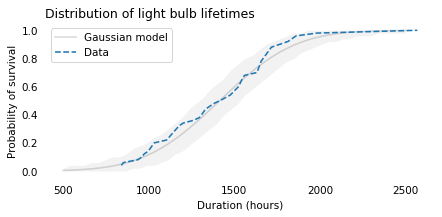

<IPython.core.display.Javascript object>

In [14]:
from empiricaldist import Cdf

qs = np.linspace(500, 2500)
ps = dist.cdf(qs)
plt.plot(qs, ps, color="gray", alpha=0.3, label="Gaussian model")


n = len(lifetimes)
low, high = normal_error_bounds(dist, n, qs)
plt.fill_between(qs, low, high, lw=0, color="gray", alpha=0.1)

surv = Cdf.from_seq(lifetimes)
surv.plot(ls="--", label="Data")
decorate(
    xlabel="Duration (hours)",
    ylabel="Probability of survival",
    title="Distribution of light bulb lifetimes",
)

The shaded area shows how much variation we expect from the Gaussian model.
Except for one unusually long-lasting bulb, the lifetimes fall within the bounds, which shows that the data are consistent with the model.

In this dataset, the average lifetime for a new light bulb is about 1414 hours.
For a bulb that has been used for 1000 hours, the average lifetime is higher, about 1495 hours; however, since it has already burned 1000 hours, its average remaining lifetime is only 495 hours.
So we would rather have the new bulb.

We can do the same calculation for a range of elapsed times from 0 to 2568 hours (the lifespan of the oldest bulb).
At each point in time, $t$, we can compute the average lifetime for bulbs that survive past $t$ and the average remaining lifetime we expect.
The following figure shows the result.

In [15]:
np.mean(lifetimes)

1413.84

<IPython.core.display.Javascript object>

In [16]:
lifetimes[lifetimes > 1000].mean()

1495.2558139534883

<IPython.core.display.Javascript object>

In [17]:
def remaining_lifetimes_seq(seq, qs=None):
    if qs is None:
        qs = np.linspace(0, seq.max(), 200)

    series = pd.Series(index=qs, dtype=float)
    for q in qs:
        conditional = seq[seq >= q]
        if len(conditional):
            series[q] = conditional.mean() - q

    return series.dropna()

<IPython.core.display.Javascript object>

In [18]:
mu, sigma = lifetimes.mean(), lifetimes.std()
dist = norm(mu, sigma)

n = len(lifetimes)
qs = pmf_lifetimes.index

<IPython.core.display.Javascript object>

In [19]:
def resample(xs):
    return np.random.choice(xs, size=len(xs), replace=True)

<IPython.core.display.Javascript object>

In [20]:
def percentile_rows(series_seq, ps):
    """Computes percentiles from aligned series.

    series_seq: list of sequences
    ps: cumulative probabilities

    returns: Series of x-values, NumPy array with selected rows
    """
    df = pd.concat(series_seq, axis=1).fillna(0)
    xs = df.index
    array = df.values.transpose()
    array = np.sort(array, axis=0)
    nrows, ncols = array.shape

    ps = np.asarray(ps)
    indices = (ps * nrows).astype(int)
    rows = array[indices]
    return xs, rows

<IPython.core.display.Javascript object>

In [21]:
def plot_percentiles(series_seq, label=None, **options):
    ps = [0.05, 0.5, 0.95]
    xs, rows = percentile_rows(series_seq, ps)
    low, med, high = rows
    plt.plot(xs, med, alpha=0.5, label=label, **options)
    plt.fill_between(xs, low, high, linewidth=0, alpha=0.2, **options)

<IPython.core.display.Javascript object>

In [22]:
np.random.seed(17)
from scipy.stats import gaussian_kde

kde = gaussian_kde(lifetimes)

res = []
qs = np.arange(0, 2550, 50)
for i in range(201):
    sample = kde.resample(len(lifetimes))
    rem = remaining_lifetimes_seq(sample, qs)
    res.append(rem)

<IPython.core.display.Javascript object>

In [23]:
x = 1000
y = lifetimes[lifetimes > 1000].mean() - x
x, y

(1000, 495.2558139534883)

<IPython.core.display.Javascript object>

In [24]:
ps = [0.5]
xs, rows = percentile_rows(res, ps)
(med,) = rows

x = 1000
y = pd.Series(med, xs)[x]

<IPython.core.display.Javascript object>

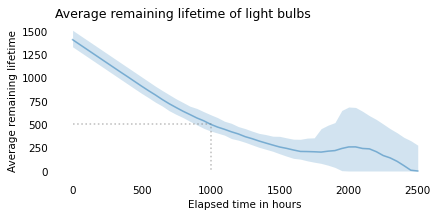

<IPython.core.display.Javascript object>

In [25]:
plt.plot([0, x, x], [y, y, 0], ":", color="gray", alpha=0.5)
plot_percentiles(res, color="C0")

decorate(
    xlabel="Elapsed time in hours",
    ylabel="Average remaining lifetime",
    title="Average remaining lifetime of light bulbs",
)

The x-axis shows elapsed times since the installation of a hypothetical light bulb.
The y-axis shows the average remaining lifetime.
In this example, a bulb that has been burning for 1000 hours is expected to last about 495 hours more, as indicated by the dotted lines.

So a new bulb generally lasts longer than a used bulb.

In [26]:
(lifetimes > 1450).sum(), (lifetimes > 1710).sum(), (lifetimes > 1800).sum()

(25, 11, 5)

<IPython.core.display.Javascript object>

In [27]:
def make_normal_pmf(qs, mu, sigma):
    ps = norm.pdf(qs, mu, sigma)
    pmf_normal = Pmf(ps, qs)
    pmf_normal.normalize()
    return pmf_normal

<IPython.core.display.Javascript object>

In [28]:
def make_normal_model(pmf):
    pmf = pmf / pmf.sum()
    mu, sigma = pmf.mean(), pmf.std()
    qs = np.linspace(0, pmf.qs.max(), 200)
    return make_normal_pmf(qs, mu, sigma)

<IPython.core.display.Javascript object>

In [29]:
def remaining_lifetimes_pmf(pmf, qs=None):
    if qs is None:
        qs = np.linspace(0, pmf.qs.max(), 200)

    series = pd.Series(index=qs, dtype=float)
    for q in qs:
        conditional = Pmf(pmf[pmf.qs >= q])
        conditional.normalize()
        series[q] = conditional.mean() - q

    return series

<IPython.core.display.Javascript object>

In [30]:
def plot_remaining_lifetimes(
    pmf_model, surv_km, surv_low, surv_high, label="", data_label="", qs=None
):
    if pmf_model is not None:
        series = remaining_lifetimes_pmf(pmf_model, qs)
        series.plot(color="C4", ls=":", label=label)

    series = remaining_lifetimes_pmf(surv_km.make_pmf(), qs)
    series.plot(ls="--", color="C1", label=data_label)

    series_low = remaining_lifetimes_pmf(surv_low.make_pmf(), qs)
    series_high = remaining_lifetimes_pmf(surv_high.make_pmf(), qs)
    plt.fill_between(series.index, series_low, series_high, color="C1", alpha=0.1)

    decorate(xlabel="Current survival time", ylabel="Average remaining survival time")

<IPython.core.display.Javascript object>

In [31]:
import lifelines
from empiricaldist import Surv


def km_fit(duration, observed):
    fit = lifelines.KaplanMeierFitter().fit(duration, observed)
    surv_km = Surv(fit.survival_function_["KM_estimate"])

    ci_fit = fit.confidence_interval_
    surv_low = Surv(ci_fit["KM_estimate_lower_0.95"])
    surv_high = Surv(ci_fit["KM_estimate_upper_0.95"])

    return surv_km, surv_low, surv_high

<IPython.core.display.Javascript object>

## Any day now

Now let's consider the question posed by the imaginary obstetrician at lunch.
Suppose you visit a maternity ward and meet women who are starting their 39th, 40th, and 41st week of pregnancy.
Which one do you think will deliver first?

To answer this question, we need to know the distribution of gestation times, which we can get from the National Survey of Family Growth (NSFG), which was the source of the birth weights in Chapter~\ref{extremes-outliers-and-goats}.
I gathered data collected between 2002 and 2017, which includes information about 43,939 live births.
The following figure shows the distribution of their durations (except for the 1% of babies born prior to 28 weeks).

In [32]:
download(DATA_PATH + "nsfg.hdf5")

<IPython.core.display.Javascript object>

In [33]:
# data cleaning is in FirstLateNSFG repo
# includes data from 2002, 2006-2010, 2011-2013, 2013-2015,  2015-2017

nsfg = pd.read_hdf("nsfg.hdf5", "nsfg")
nsfg.shape

(62539, 7)

<IPython.core.display.Javascript object>

In [34]:
nsfg.head()

,pregend1,nbrnaliv,prglngth,outcome,birthord,finalwgt,cycle
0,6.0,1.0,40,1,1.0,19877.457610,10
1,1.0,NaN,14,4,NaN,19877.457610,10
2,6.0,1.0,39,1,2.0,19877.457610,10
3,6.0,1.0,39,1,1.0,4221.017695,10
4,6.0,1.0,39,1,2.0,4221.017695,10


<IPython.core.display.Javascript object>

In [35]:
live = nsfg["outcome"] == 1
reasonable = nsfg["prglngth"] < 45

lengths = nsfg.loc[live & reasonable, "prglngth"]
pmf_length = Pmf.from_seq(lengths)
len(lengths)

43246

<IPython.core.display.Javascript object>

In [36]:
(lengths < 28).mean() * 100

0.9272533875965407

<IPython.core.display.Javascript object>

In [37]:
gt = pmf_length.qs >= 28
pmf_length_gt = Pmf(pmf_length[gt] * 100)

<IPython.core.display.Javascript object>

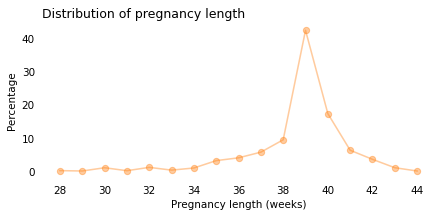

<IPython.core.display.Javascript object>

In [38]:
pmf_length_gt.plot(color="C1", marker="o", alpha=0.4)

decorate(
    xlabel="Pregnancy length (weeks)",
    ylabel="Percentage",
    title="Distribution of pregnancy length",
    xticks=np.arange(28, 46, 2),
)

About 41% of these births were during the 39th week of pregnancy, and another 18% during the 40th week.

In [39]:
lengths.mean(), pmf_length_gt[39], pmf_length_gt[40]

(38.505341534477175, 42.357674698237986, 17.400453221107153)

<IPython.core.display.Javascript object>

In [40]:
for name, group in nsfg.groupby("cycle"):
    print(name, len(group))

6 13593
7 20492
8 9543
9 9358
10 9553


<IPython.core.display.Javascript object>

In [41]:
def sample_by_cycle(df):
    sample = df.groupby("cycle").sample(frac=1, replace=True, weights="finalwgt")
    return sample

<IPython.core.display.Javascript object>

In [42]:
qs = np.arange(36, 44)
mrt_seq = []

for i in range(101):
    sample = sample_by_cycle(nsfg)

    live = sample["outcome"] == 1
    reasonable = sample["prglngth"] < 50

    lengths = sample.loc[live & reasonable, "prglngth"]
    mrt = remaining_lifetimes_seq(lengths, qs)

    mrt_seq.append(mrt)

<IPython.core.display.Javascript object>

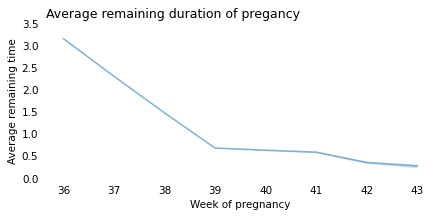

<IPython.core.display.Javascript object>

In [43]:
plot_percentiles(mrt_seq, color="C0")

decorate(
    xlabel="Week of pregnancy",
    ylabel="Average remaining time",
    title="Average remaining duration of pregancy",
    ylim=[0, 3.5],
)

Between weeks 36 and 39, the curve behaves as we expect: as time goes on, we get closer to the finish line.
For example, at the beginning of week 36, the average remaining time is 3.2 weeks.
At the beginning of week 37, it is down to 2.3 weeks.
So far, so good: a week goes by and the finish line is just about one week closer.

But then, cruelly, the curve levels off.
At the beginning of week 39, the average remaining time is 0.68 weeks, so the end seems near.
But if we get to the beginning of week 40, and the baby has not been born, the average remaining time is 0.63 weeks.
A week has passed and the finish line is only 8 hours closer.

And if we get to the beginning of week 41, and the baby has not been born, the average remaining time is 0.59 weeks.
Another week has passed and the finish line is only 7 hours closer!

In [44]:
xs, ys = percentile_rows(mrt_seq, [0.025, 0.5, 0.975])
df = pd.DataFrame(np.transpose(ys), xs, columns=[2.5, 50, 97.5])
df

,2.5,50.0,97.5
36,3.142822,3.153736,3.165931
37,2.292390,2.303369,2.316928
38,1.465161,1.474933,1.488573
39,0.669659,0.679651,0.692118
40,0.612146,0.629809,0.647226
41,0.560671,0.586682,0.611351
42,0.320918,0.352373,0.382273
43,0.220000,0.271242,0.340611


<IPython.core.display.Javascript object>

In [45]:
df[50].diff().loc[[40, 41]] * 7 * 24

40   -8.373551
41   -7.245228
Name: 50.0, dtype: float64

<IPython.core.display.Javascript object>

## Cancer survival times

Finally, let's consider the surprising result reported by the imaginary oncologist at lunch: for many cancers, a patient who has survived a year after diagnosis is expected to live longer than someone who has just been diagnosed.

To demonstrate and explain this result, I'll use data from the the Surveillance, Epidemiology, and End Results (SEER) program, which is run by the U.S. National Institutes of Health (NIH).
Starting in 1973, SEER has collected data on cancer cases from registries in several locations in the United States.
In the most recent datasets, these registries cover about one third of the U.S. population.

NOTE: I am definitely not allowed to redistribute SEER data, so the data in this example in synthetic; that is, I have generated random data that is statistically similar to the actual data I reported in the book. The results below will differ from what's in the book, but the conclusions are qualitatively similar.

In [46]:
brain = pd.read_hdf("brain.hdf", "brain")
brain.shape

(16202, 2)

<IPython.core.display.Javascript object>

In [47]:
brain.head()

,duration,observed
0,4.50,True
1,15.75,True
2,10.75,True
3,6.25,True
4,29.50,True


<IPython.core.display.Javascript object>

From the SEER data I selected the 16,202 cases of glioblastoma, diagnosed between 2000 and 2016, where the survival times are available.
We can use this data to infer the distribution of survival times, but first we have to deal with a statistical obstacle: some of the patients are still alive, or were alive the last time they appeared in a registry.

For these cases, the time until their death is unknown, which is a good thing.
However, in order to work with data like this, we need a special method, called Kaplan-Meier estimation, to compute the distribution of lifetimes.
The following figure shows the result on a log scale, plotted in the familiar form of a CDF and in a new form called a survival curve.

In [48]:
observed = brain["observed"]
observed.sum()

14548

<IPython.core.display.Javascript object>

In [49]:
duration = brain["duration"]
duration.describe()

count    16202.000000
mean        13.457783
std         19.088951
min          0.250000
25%          3.250000
50%          7.750000
75%         16.500000
max        201.750000
Name: duration, dtype: float64

<IPython.core.display.Javascript object>

In [50]:
(duration[observed] == 0).mean(), (duration[~observed] == 0).mean()

(0.0, 0.0)

<IPython.core.display.Javascript object>

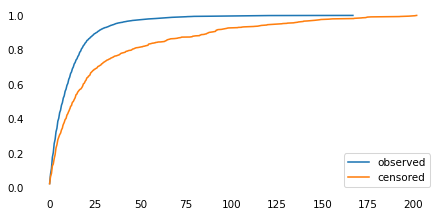

<IPython.core.display.Javascript object>

In [51]:
Cdf.from_seq(duration[observed]).plot(label="observed")
Cdf.from_seq(duration[~observed]).plot(label="censored")

decorate(xscale="linear")

In [52]:
surv_km, surv_low, surv_high = km_fit(duration, observed)
surv_km.head()

,probs
timeline,
0.00,1.00000
0.25,0.97667
0.50,0.95130


<IPython.core.display.Javascript object>

In [53]:
def plot_fit(surv_km, surv_low, surv_high, **options):
    xs = surv_low.index
    plt.fill_between(xs, surv_low, surv_high, color="gray", alpha=0.3)
    surv_km.plot(**options)

<IPython.core.display.Javascript object>

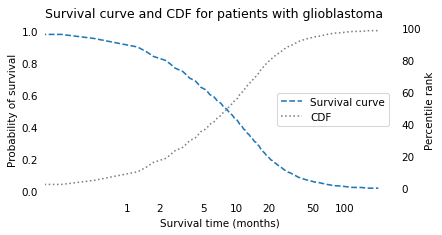

<IPython.core.display.Javascript object>

In [54]:
ax1 = plt.gca()
surv_km.plot(ls="--", label="Survival curve")
h1, l1 = plt.gca().get_legend_handles_labels()
plt.ylabel("Probability of survival")
plt.xlabel("Survival time (months)")

plt.xscale("log")
labels = [1, 2, 5, 10, 20, 50, 100]
ticks = labels
plt.xticks(ticks, labels)

ax2 = plt.twinx()
ax1.tick_params(left=False, right=False)

cdf = surv_km.make_cdf() * 100
cdf.plot(color="gray", ls=":", label="CDF")
h2, l2 = plt.gca().get_legend_handles_labels()
plt.legend(h1 + h2, l1 + l2, loc="center right")
plt.ylabel("Percentile rank")

plt.title("Survival curve and CDF for patients with glioblastoma")
ax2.tick_params(left=False, right=False)

The survival curve shows the probability of survival past a given time on a scale from 0 to 1.
It is the complement of the CDF, so as the CDF increases from left to right, the survival curve decreases.
The two curves contain the same information; the only reason to use one or the other is convention.
Survival curves are used more often in medicine and reliability engineering, CDFs in many other fields.

One thing that is apparent -- from either curve -- is that glioblastoma is a serious diagnosis.
The median survival time after diagnosis is less than 9 months, and only about 16% of patients survive more than two years.

Please keep in mind that this curve lumps together people of different ages with different health conditions, diagnosed at different stages of disease over a period of about 16 years.
Survival times depend on all of these factors, so this curve does not provide a prognosis for any specific patient.
In particular, as treatment has gradually improved, the prognosis is better for someone with a more recent diagnosis.
If you or someone you know is diagnosed with glioblastoma, you should get a prognosis from a doctor, based on specifics of the case, not from aggregated data in a book demonstrating basic statistical methods.

In [55]:
def make_km_plot(duration, observed, **options):
    surv_km, surv_low, surv_high = km_fit(duration, observed)
    surv_km.drop(0, inplace=True)
    surv_low.drop(0, inplace=True)
    surv_high.drop(0, inplace=True)

    surv_lognormal = fit_lognormal(surv_km)
    surv_lognormal.plot(**options)

    plot_fit(surv_km, surv_low, surv_high)

<IPython.core.display.Javascript object>

As we did with light bulbs and pregnancy lengths, we can use this distribution to compute the average remaining survival time for patients at each time after diagnosis.
The following figure shows the result.

<AxesSubplot: >

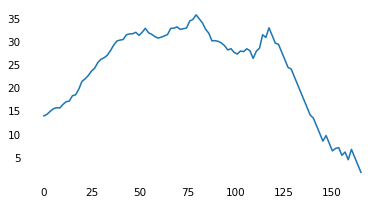

<IPython.core.display.Javascript object>

In [56]:
surv_km, surv_high, surv_low = km_fit(duration, observed)
qs = np.linspace(0, 165, 101)

rem = remaining_lifetimes_pmf(surv_km.make_pmf(), qs)
rem.plot()

In [57]:
np.random.seed(17)
rem_seq = []
for i in range(101):
    sample = brain.sample(frac=1, replace=True)
    observed = sample["observed"]
    duration = sample["duration"]
    surv_km, surv_high, surv_low = km_fit(duration, observed)
    rem = remaining_lifetimes_pmf(surv_km.make_pmf(), qs)
    # rem.plot(color="gray", alpha=0.01)
    rem_seq.append(rem)

<IPython.core.display.Javascript object>

In [58]:
def gray_box(x_max=170):
    """Make a gray box that spans the y-axis."""
    plt.axvspan(125, x_max, color="gray", alpha=0.1)
    plt.xlim([-5, x_max])

<IPython.core.display.Javascript object>

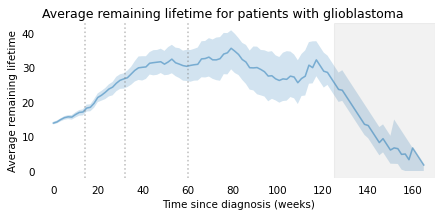

<IPython.core.display.Javascript object>

In [59]:
plot_percentiles(rem_seq)
gray_box()
for x in [14, 32, 60]:
    plt.axvline(x, color="gray", ls=":", alpha=0.5)
decorate(
    xlabel="Time since diagnosis (weeks)",
    ylabel="Average remaining lifetime",
    title="Average remaining lifetime for patients with glioblastoma",
)

At the time of diagnosis, the average survival time is about 14 months.
That is certainly a bleak prognosis, but there is some good news to follow.
If a patient survives the first 14 months, we expect them to survive another 18 months, on average.
If they survive those 18 months, for a total of 32, we expect them to survive another 28 months.
And if they survive those 28 months, for a total of 60 months (five years), we expect them to survive another 35 months (almost three years).
The vertical lines indicate these milestones.
It's like running a race where the finish line keeps moving, and the farther you go, the faster it retreats.

In [60]:
qs = np.arange(0, 165)
series = remaining_lifetimes_pmf(surv_km.make_pmf(), qs)
series[[0, 14, 32, 60]]

0     13.773990
14    17.069424
32    24.735119
60    27.839032
dtype: float64

<IPython.core.display.Javascript object>

If you hear that the average survival time after diagnosis is 14 months, you might imagine a Gaussian distribution where 14 months is the most common value and an equal number of patients live more or less than 14 months.
But that would be a very misleading picture.

To show how bad it would be, I chose a Gaussian distribution that matches the distribution of survival times as well as possible -- which is not very well -- and used it to compute average remaining survival times.
The following figure shows the result, along with the actual averages.

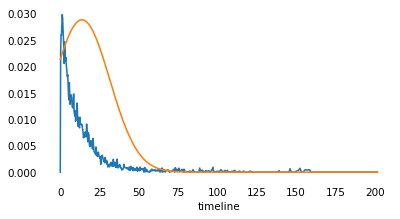

<IPython.core.display.Javascript object>

In [61]:
pmf_km = surv_km.make_pmf()
pmf_normal = make_normal_model(pmf_km)

pmf_km.plot()
pmf_normal.plot()
None

In [62]:
series = remaining_lifetimes_pmf(pmf_normal)
series.tail()

197.694724    0.972382
198.708543    0.829894
199.722362    0.630459
200.736181    0.358620
201.750000    0.000000
dtype: float64

<IPython.core.display.Javascript object>

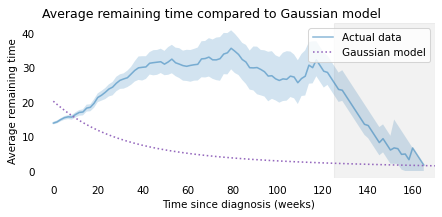

<IPython.core.display.Javascript object>

In [63]:
plot_percentiles(rem_seq, label="Actual data")
series.plot(color="C4", ls=":", label="Gaussian model")

gray_box()
decorate(
    xlabel="Time since diagnosis (weeks)",
    ylabel="Average remaining time",
    title="Average remaining time compared to Gaussian model",
    loc="upper right",
)

With the Gaussian model, the average remaining survival time starts around 20 months,
drops quickly at first, and levels off around 5 months.
So it behaves nothing like the actual averages.

On the other hand, if your mental model of the distribution is lognormal, you would get it about right.
To demonstrate, I chose a lognormal distribution that fits the actual distribution of survival times and used it to compute average remaining lifetimes.
The following figure shows the result.

In [64]:
def error_func_lognormal(params, surv_km):
    # print(params)
    mu, sigma = params
    xs = surv_km.index
    xs = xs[xs >= 1]
    xs = np.linspace(1, np.max(xs))
    xs = np.logspace(0, 2)

    ps = norm.sf(np.log(xs), mu, sigma)
    error = ps - surv_km(xs)
    return error

<IPython.core.display.Javascript object>

In [65]:
def fit_lognormal(surv, xs=None):
    data = (surv,)
    params = surv.mean(), surv.std()
    res = least_squares(error_func_lognormal, x0=params, args=data, xtol=1e-3)
    assert res.success
    mu, sigma = res.x

    if xs is None:
        xs = surv.index
    ps = norm.sf(np.log(xs), mu, sigma)
    return Surv(ps, xs)

<IPython.core.display.Javascript object>

In [66]:
surv_lognormal = fit_lognormal(surv_km)
pmf_lognormal = surv_lognormal.make_pmf()

<IPython.core.display.Javascript object>

In [67]:
series = remaining_lifetimes_pmf(pmf_lognormal)

<IPython.core.display.Javascript object>

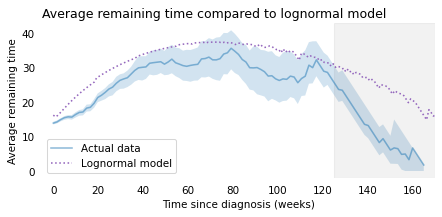

<IPython.core.display.Javascript object>

In [68]:
plot_percentiles(rem_seq, label="Actual data")
series.plot(color="C4", ls=":", label="Lognormal model")
gray_box()

decorate(
    xlabel="Time since diagnosis (weeks)",
    ylabel="Average remaining time",
    title="Average remaining time compared to lognormal model",
)
plt.legend(loc="lower left")
None

During the first 24 months, the model is a little too optimistic, and after 120 months it is much too optimistic.
But the lognormal model gets the shape of the curve right: if your mental model of the distribution is lognormal, you would have a reasonably accurate understanding of the situation.

## Life Expectancy At Birth

In 2012, a team of demographers at the University of Southern California estimated life expectancy for people born in Sweden in the early 1800s and 1900s.
They chose Sweden because it "has the deepest historical record of high-quality [demographic] data."

For ages from 0 to 91 years, they estimated the mortality rate, which is the fraction of people at each age who die.
The following figure shows the results for two cohorts: people born between 1800 and 1810, and people born between 1905 and 1915.

In [69]:
download(DATA_PATH + "mortality_rates_beltran2012.csv")

<IPython.core.display.Javascript object>

In [70]:
mortality = pd.read_csv("mortality_rates_beltran2012.csv", header=[0, 1])
mortality.head()

1905                1800          
          X         Y         X         Y
0  0.056633 -2.685744  0.066515 -1.541222
1  0.175223 -2.866213  0.224635 -1.692583
2  0.293812 -3.043189  0.362990 -1.890516
3  0.412402 -3.216672  0.481580 -2.052938
4  0.530992 -3.390155  0.623887 -2.239811

<IPython.core.display.Javascript object>

In [71]:
def make_series(x, y):
    return pd.Series(y, x).dropna()

<IPython.core.display.Javascript object>

In [72]:
mort1800 = make_series(mortality["1800", "X"], mortality["1800", "Y"].values)
mort1800.head()

(1800, X)
0.066515   -1.541222
0.224635   -1.692583
0.362990   -1.890516
0.481580   -2.052938
0.623887   -2.239811
dtype: float64

<IPython.core.display.Javascript object>

In [73]:
mort1905 = make_series(mortality["1905", "X"], mortality["1905", "Y"].values)
mort1905.head()

(1905, X)
0.056633   -2.685744
0.175223   -2.866213
0.293812   -3.043189
0.412402   -3.216672
0.530992   -3.390155
dtype: float64

<IPython.core.display.Javascript object>

In [74]:
np.exp(mort1800.iloc[0]), np.exp(mort1905.iloc[0])

(0.21411938757305218, 0.06817045483264002)

<IPython.core.display.Javascript object>

In [75]:
from scipy.interpolate import interp1d
from empiricaldist import Hazard


def make_hazard(series):
    interp = interp1d(series.index, series.values, fill_value="extrapolate")
    xs = np.arange(0, 108)
    ys = np.exp(interp(xs))
    return Hazard(ys, xs)

<IPython.core.display.Javascript object>

In [76]:
haz1800 = make_hazard(mort1800)
haz1905 = make_hazard(mort1905)

<IPython.core.display.Javascript object>

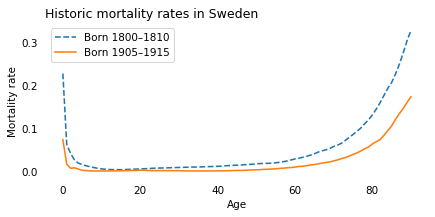

<IPython.core.display.Javascript object>

In [77]:
haz1800[:91].plot(label="Born 1800–1810", ls="--")
haz1905[:91].plot(label="Born 1905–1915")

decorate(
    xlabel="Age", ylabel="Mortality rate", title="Historic mortality rates in Sweden"
)

The notable feature is that mortality rates were lower for the later cohort at every age.

In [78]:
haz1800[0], haz1905[0]

(0.2281961996457684, 0.07430619990025686)

<IPython.core.display.Javascript object>

In [79]:
haz1800.min(), haz1800.idxmin(), haz1905[14]

(0.004624153294009557, 14, 0.0019040788545011136)

<IPython.core.display.Javascript object>

In [80]:
haz1800[80], haz1905[80]

(0.13156208289057392, 0.06441158462898641)

<IPython.core.display.Javascript object>

The following figure shows life expectancy as a function of age for people born in Sweden around 1800 and 1905.

In [81]:
pmf1800 = haz1800.make_pmf()
pmf1800.normalize()

0.9999999998644409

<IPython.core.display.Javascript object>

In [82]:
pmf1905 = haz1905.make_pmf()
pmf1905.normalize()

0.9999711879585407

<IPython.core.display.Javascript object>

In [83]:
pmf1800.mean(), pmf1905.mean()

(36.473535530889244, 65.67277539967878)

<IPython.core.display.Javascript object>

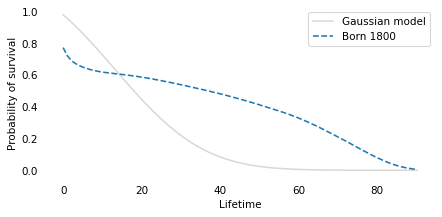

<IPython.core.display.Javascript object>

In [84]:
pmf_normal.make_surv()[:91].plot(color="gray", alpha=0.3, label="Gaussian model")
pmf1800.make_surv()[:91].plot(label="Born 1800", ls="--")
pmf_normal = make_normal_model(pmf1800)

decorate(xlabel="Lifetime", ylabel="Probability of survival")

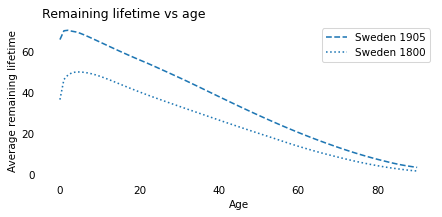

<IPython.core.display.Javascript object>

In [85]:
def draw_lines(pmf, series):
    x = pmf.mean()
    y = series[int(round(x))]
    plt.plot([0, x, x], [y, y, 0], ":", color="gray", alpha=0.5)


qs = np.arange(0, 91)
series1905 = remaining_lifetimes_pmf(pmf1905, qs)
# draw_lines(pmf1905, series1905)
series1905.plot(ls="--", color="C0", label="Sweden 1905")

series1800 = remaining_lifetimes_pmf(pmf1800, qs)
# draw_lines(pmf1800, series1800)
series1800.plot(ls=":", color="C0", label="Sweden 1800")

decorate(
    xlabel="Age", ylabel="Average remaining lifetime", title="Remaining lifetime vs age"
)

In both cohorts, used was better than new, at least for the first few years of life.

In [142]:
series1800[0], series1800.idxmax(), series1800.max()

(36.473535530889244, 5, 49.9171982587444)

<IPython.core.display.Javascript object>

In [143]:
series1905[0], series1905.idxmax(), series1905.max()

(65.67277539967881, 2, 70.18860681489375)

<IPython.core.display.Javascript object>

In [144]:
series1800[0], series1800[36], series1800[65]

(36.473535530889244, 29.241600197695945, 11.018435234417836)

<IPython.core.display.Javascript object>

In [145]:
series1905[5]

68.80456362586426

<IPython.core.display.Javascript object>

In [146]:
series1905[0], series1905[66], series1905[82]

(65.67277539967881, 16.058634133594552, 6.471530454841982)

<IPython.core.display.Javascript object>

## Child mortality

The following figure shows the percentage of children who die before age 5 for four geographical regions, from 1900 to 2019.
These data were combined from several sources by Gapminder, a foundation based in Sweden that "promotes sustainable global development [...] by increased use and understanding of statistics."

Documentation of the data is at <https://www.gapminder.org/data/documentation/gd005>

The data is in [this online spreadsheet](https://docs.google.com/spreadsheets/d/1Av7eps_zEK73-AdbFYEmtTrwFKlfruBYXdrnXAOFVpM/edit#gid=501532268)

In [91]:
download(DATA_PATH + "GM-ChildMortality-Dataset-v11.xlsx")

<IPython.core.display.Javascript object>

In [92]:
gm = pd.read_excel(
    "GM-ChildMortality-Dataset-v11.xlsx", sheet_name="data-for-regions-by-year"
)
gm.tail()

,geo,name,time,Child mortality
1199,americas,The Americas,2096,2.70
1200,americas,The Americas,2097,2.67
1201,americas,The Americas,2098,2.63
1202,americas,The Americas,2099,2.60
1203,americas,The Americas,2100,2.59


<IPython.core.display.Javascript object>

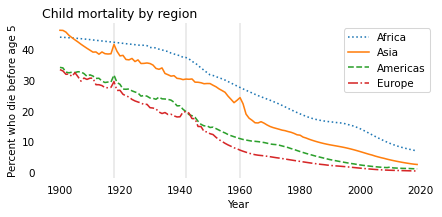

<IPython.core.display.Javascript object>

In [93]:
grouped = gm.groupby("geo")
line_styles = {"africa": ":", "asia": "-", "americas": "--", "europe": "-."}

for x in [1918, 1942, 1960]:
    plt.axvline(x, color="gray", alpha=0.2)

for name in ["africa", "asia", "americas", "europe"]:
    group = grouped.get_group(name)
    series = pd.Series(group["Child mortality"].values / 10, group["time"])
    series.loc[1900:2019].plot(label=name.title(), ls=line_styles[name])

decorate(
    xlabel="Year",
    ylabel="Percent who die before age 5",
    title="Child mortality by region",
)

In every region, child mortality has decreased consistently and substantially.

I collected recent mortality data from the [Global Health Observatory](https://apps.who.int/gho/data/node.main.LIFECOUNTRY?lang=en) of the World Health Organization (WHO).
For people born in 2019, we don't know what their future lifetimes will be, but we can estimate it if we assume that the mortality rate in each age group will not change over their lifetimes.

Based on that simplification, the following figure shows average remaining lifetime as a function of age for Sweden and Nigeria in 2019, compared to Sweden in 1905.

In [94]:
def read_hazard(filename):
    df = pd.read_csv(filename, header=[1])

    nmx = df.query(
        'Indicator == "nMx - age-specific death rate between ages x and x+n"'
    )

    index = nmx["Age Group"].values
    ages = np.arange(-5, 90, 5)
    age_series = pd.Series(ages, index)
    age_series.iloc[[0, 1]] = [0, 1]

    rate = nmx["Both sexes"]
    rate.index = age_series.values
    hazard = rate.reindex(np.arange(111)).fillna(method="ffill")
    return Hazard(hazard)

<IPython.core.display.Javascript object>

In [95]:
download(DATA_PATH + "life_table_sweden.csv")
download(DATA_PATH + "life_table_sweden_2019.csv")
download(DATA_PATH + "life_table_nigeria_2019.csv")

<IPython.core.display.Javascript object>

In [96]:
filename = "life_table_sweden_2019.csv"
hazard = read_hazard(filename)

pmf_swe = hazard.make_pmf()
pmf_swe.normalize()
pmf_swe.mean()

81.6599453119953

<IPython.core.display.Javascript object>

In [97]:
filename = "../data/life_table_nigeria_2019.csv"
hazard = read_hazard(filename)
hazard.head()

,probs
0,0.077958
1,0.011613
2,0.011613


<IPython.core.display.Javascript object>

In [98]:
pmf_nga = hazard.make_pmf()
pmf_nga.normalize()
pmf_nga.mean()

61.59620754538476

<IPython.core.display.Javascript object>

<AxesSubplot: >

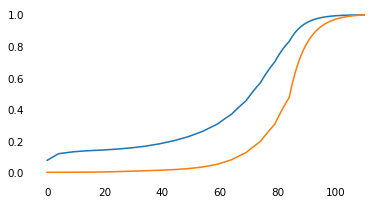

<IPython.core.display.Javascript object>

In [99]:
pmf_nga.make_cdf().plot()
pmf_swe.make_cdf().plot()

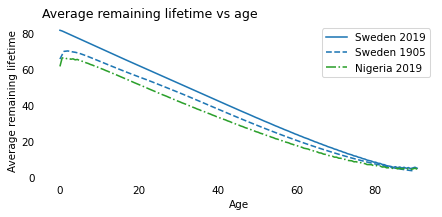

<IPython.core.display.Javascript object>

In [100]:
rem_swe = remaining_lifetimes_pmf(pmf_swe)
rem_nga = remaining_lifetimes_pmf(pmf_nga)

rem_swe[:91].plot(label="Sweden 2019", ls="-")
series1905.plot(ls="--", color="C0", label="Sweden 1905")
rem_nga[:91].plot(ls="-.", label="Nigeria 2019", color="C2")

decorate(
    xlabel="Age",
    ylabel="Average remaining lifetime",
    title="Average remaining lifetime vs age",
)

In [147]:
rem_nga.head()

0.000000    61.596208
0.552764    66.256747
1.105528    66.478013
1.658291    65.925249
2.211055    66.143866
dtype: float64

<IPython.core.display.Javascript object>

## The Immortal Swede

Going back to the data from Sweden, the following figure shows the mortality rate for each age group, updated every ten years from 2000 to 2019.

In [102]:
columns = ["Indicator", "Age Group", 2019, 2015, 2010, 2005, 2000]
df = pd.read_csv("../data/life_table_sweden.csv", header=[1])
df.columns = columns
df.head()

,Indicator,Age Group,2019,2015,2010,2005,2000
0,nMx - age-specific death rate between ages x a...,<1 year,0.002042,0.002452,0.002579,0.002448,0.003451
1,nMx - age-specific death rate between ages x a...,1-4 years,0.000121,0.000127,0.000150,0.000211,0.000123
2,nMx - age-specific death rate between ages x a...,5-9 years,0.000061,0.000068,0.000063,0.000102,0.000097
3,nMx - age-specific death rate between ages x a...,10-14 years,0.000081,0.000110,0.000090,0.000101,0.000134
4,nMx - age-specific death rate between ages x a...,15-19 years,0.000217,0.000230,0.000271,0.000262,0.000355


<IPython.core.display.Javascript object>

In [103]:
index = df["Age Group"].values
ages = np.arange(-5, 90, 5)
age_series = pd.Series(ages, index)
age_series.iloc[[0, 1]] = [0, 1]
age_series

<1 year          0
1-4 years        1
5-9 years        5
10-14 years     10
15-19  years    15
20-24 years     20
25-29 years     25
30-34 years     30
35-39 years     35
40-44 years     40
45-49 years     45
50-54 years     50
55-59 years     55
60-64 years     60
65-69 years     65
70-74 years     70
75-79 years     75
80-84 years     80
85+ years       85
dtype: int64

<IPython.core.display.Javascript object>

In [104]:
df.drop(columns=["Indicator", "Age Group"], inplace=True)
df.index = age_series.values
df

,2019,2015,2010,2005,2000
0,0.002042,0.002452,0.002579,0.002448,0.003451
1,0.000121,0.000127,0.000150,0.000211,0.000123
5,0.000061,0.000068,0.000063,0.000102,0.000097
10,0.000081,0.000110,0.000090,0.000101,0.000134
15,0.000217,0.000230,0.000271,0.000262,0.000355
20,0.000407,0.000457,0.000458,0.000472,0.000511
25,0.000549,0.000575,0.000498,0.000500,0.000499
30,0.000598,0.000563,0.000505,0.000498,0.000524
35,0.000631,0.000604,0.000570,0.000710,0.000827
40,0.000836,0.000860,0.000916,0.001102,0.001240


<IPython.core.display.Javascript object>

In [105]:
from utils import Re70, Or70, Gr60, Bl50, Pu40


def plot_mortality(df):
    df[2000].plot(lw=1, style="x-", color=Re70)
    # df[2005].plot(lw=1, ms=4, style="^--", color=Or70)
    df[2010].plot(lw=1, ms=4, style="s--", color=Gr60)
    # df[2015].plot(lw=1, ms=4, style="*--", color=Bl50)
    df[2019].plot(lw=1, ms=4, style="o-", color=Pu40)

    decorate(xlabel="Age", ylabel="Mortality rate", yscale="log")

<IPython.core.display.Javascript object>

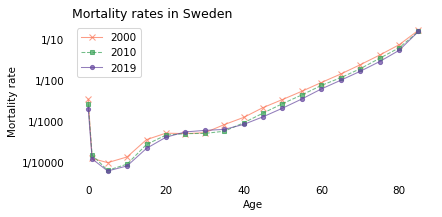

<IPython.core.display.Javascript object>

In [106]:
plot_mortality(df)
labels = ["1/10", "1/100", "1/1000", "1/10000"]
ticks = [1e-1, 1e-2, 1e-3, 1e-4]
plt.yticks(ticks, labels)
decorate(title="Mortality rates in Sweden")

The straight-line increase after age 35 was described by Benjamin Gompertz in 1825, so this phenomenon is called the Gompertz Law.
It is an empirical law, which is to say that it names a pattern we see in nature, but at this point we don't have an explanation of why it's true, or whether it is certain to be true in the future.
Nevertheless, the data in this example fall in a remarkably straight line.

In [107]:
df.loc[[0, 50], 2019] * 100

0     0.204202
50    0.208688
Name: 2019, dtype: float64

<IPython.core.display.Javascript object>

In [108]:
df.loc[[10, 40, 65, 85], 2019] * 100

10     0.008100
40     0.083590
65     1.005406
85    15.695439
Name: 2019, dtype: float64

<IPython.core.display.Javascript object>

The previous figure also shows that mortality rates decreased between 2000 and 2019 in almost every age group.
If we zoom in on the age range from 40 to 80, we can see the changes in adult mortality more clearly.

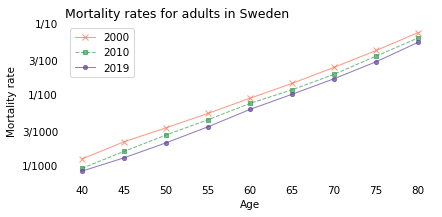

<IPython.core.display.Javascript object>

In [109]:
subset = df.loc[40:80]
plot_mortality(subset)


def add_yticks():
    labels = ["1/10", "3/100", "1/100", "3/1000", "1/1000"]
    ticks = [1e-1, 3e-2, 1e-2, 3e-3, 1e-3]
    plt.yticks(ticks, labels)


add_yticks()
decorate(title="Mortality rates for adults in Sweden")

In [110]:
data = subset.stack().reset_index()
data.columns = ["age", "year", "rate"]
data["log_rate"] = np.log10(data["rate"])
data.head()

,age,year,rate,log_rate
0,40,2019,0.000836,-3.077846
1,40,2015,0.000860,-3.065354
2,40,2010,0.000916,-3.038094
3,40,2005,0.001102,-2.957944
4,40,2000,0.001240,-2.906429


<IPython.core.display.Javascript object>

In [111]:
import statsmodels.formula.api as smf

formula = "log_rate ~ age + year"

results = smf.ols(formula, data=data).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_rate   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.581e+04
Date:                Tue, 14 Feb 2023   Prob (F-statistic):           3.78e-61
Time:                        08:58:37   Log-Likelihood:                 109.74
No. Observations:                  45   AIC:                            -213.5
Df Residuals:                      42   BIC:                            -208.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.5134      0.964     14.017      0.000      11.568      15.459
age            0.0446      0.000    176.799      0.000       0.044       0.045
year          -0.0091      0.000    -19.003      0.000      -0.010      -0.008
==============================================================================
Omnibus:                        2.326   Durbin-Watson:                   1.177
Prob(Omnibus):                  0.313   Jarque-Bera (JB):                2.195
Skew:                           0.507   Prob(JB):                        0.334
Kurtosis:                       2.623   Cond. No.                     5.95e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.95e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>

In these age groups, the decreases in mortality have been remarkably consistent.
By fitting a model to this data, we can estimate the rate of change as a function of both age and time.
According to the model, as you move from one age group to the next, your mortality rate increases by about 11% per year.
At the same time, for the reasons I just mentioned, the mortality rate in every age group decreases by about 2% per year.

These results imply that the life expectancies we computed in the previous section are too pessimistic because they take into account only the first effect -- the increase with age -- and not the second -- the decrease over time.
So let's see what happens if we include the second effect as well, that is, if we assume that mortality rates will continue to decrease.

The following figure shows the actual mortality rates for 2000 and 2019 again, along with predictions for 2040 and 2060.

In [112]:
ratios = 10**results.params
ratios["age"] - 1, ratios["year"] - 1

(0.10821618126745203, -0.02076728510750292)

<IPython.core.display.Javascript object>

In [113]:
def make_pred(subset, results, year):
    pred_frame = pd.DataFrame(dtype=float)
    pred_frame["age"] = subset.index.values
    pred_frame["year"] = year

    pred = 10 ** results.predict(pred_frame)
    pred.index = subset.index
    return Hazard(pred)

<IPython.core.display.Javascript object>

In [114]:
from empiricaldist import Hazard


def pred_hazard(results, pred_frame):
    hazard = Hazard(10 ** results.predict(pred_frame))
    hazard.index = pred_frame["age"]
    return hazard

<IPython.core.display.Javascript object>

In [115]:
pred_frame = pd.DataFrame(dtype=float)
pred_frame["age"] = np.arange(40, 105)
pred_frame["year"] = 2019
hazard_no_progress = pred_hazard(results, pred_frame)

<IPython.core.display.Javascript object>

In [116]:
pred_frame = pd.DataFrame(dtype=float)
pred_frame["age"] = np.arange(40, 120)
pred_frame["year"] = 2019 + pred_frame["age"] - 40
hazard_progress = pred_hazard(results, pred_frame)

<IPython.core.display.Javascript object>

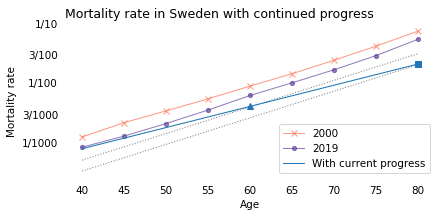

<IPython.core.display.Javascript object>

In [117]:
subset[2000].plot(lw=1, style="x-", color=Re70)
subset[2019].plot(lw=1, ms=4, style="o-", color=Pu40)

pred = make_pred(subset, results, 2040)
pred.plot(style=":", lw=1, color="gray")

pred = make_pred(subset, results, 2060)
pred.plot(style=":", lw=1, color="gray")

for x, marker in zip([60, 80], ["^", "s"]):
    y = hazard_progress[x]
    plt.plot(x, y, marker, color="C0")

hazard_progress.loc[:80].plot(lw=1, label="With current progress")

decorate(xlabel="Age", ylabel="Mortality rate", yscale="log")
add_yticks()
decorate(title="Mortality rate in Sweden with continued progress", loc="lower right")

The line labeled "With current progress" indicates the mortality rates we expect for a hypothetical Swede who was 40 in 2020.
When they are 60, it will be 2040, so we expect them to have the mortality rate of a 60-year-old in 2040, indicated by a triangle.
And when they are 80, it will be 2060, so we expect them to have the mortality rate of an 80-year-old in 2060, indicated by a square.

We can use these mortality rates to compute survival curves, as shown in the following figure.

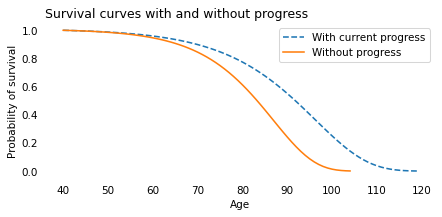

<IPython.core.display.Javascript object>

In [118]:
hazard_progress.make_surv().plot(ls="--", label="With current progress")
hazard_no_progress.make_surv().plot(label="Without progress")

decorate(
    xlabel="Age",
    ylabel="Probability of survival",
    title="Survival curves with and without progress",
)

In [119]:
def hypothetical_results(b2):
    results = smf.ols(formula, data=data).fit()
    i1, a1, b1 = results.params
    i2 = i1 + (b1 - b2) * 2019
    results.params["Intercept"] = i2
    results.params["year"] = b2
    return results

<IPython.core.display.Javascript object>

In [120]:
def hazard_hypo_progress(b2, upper):
    hypo = hypothetical_results(b2)
    pred_frame = pd.DataFrame(dtype=float)
    pred_frame["age"] = np.arange(40, upper)
    pred_frame["year"] = 2019 + pred_frame["age"] - 40
    return pred_hazard(hypo, pred_frame)

<IPython.core.display.Javascript object>

In [121]:
b2 = results.params["year"] * 2
hazard_progress2 = hazard_hypo_progress(b2, 145)

<IPython.core.display.Javascript object>

In [122]:
b3 = results.params["year"] * 3
hazard_progress3 = hazard_hypo_progress(b3, 180)

<IPython.core.display.Javascript object>

In [123]:
b4 = results.params["year"] * 4
hazard_progress4 = hazard_hypo_progress(b4, 300)

<IPython.core.display.Javascript object>

In [124]:
results.params["age"] / results.params["year"]

-4.89621102405056

<IPython.core.display.Javascript object>

In [125]:
b49 = -results.params["age"]
hazard_progress49 = hazard_hypo_progress(b49, 8000)

<IPython.core.display.Javascript object>

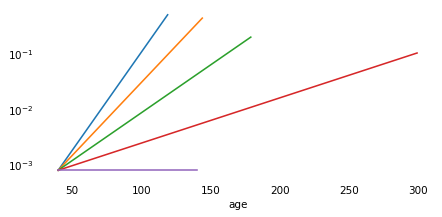

<IPython.core.display.Javascript object>

In [126]:
hazard_progress.plot()
hazard_progress2.plot()
hazard_progress3.plot()
hazard_progress4.plot()
hazard_progress49.loc[:140].plot()

decorate(yscale="log")

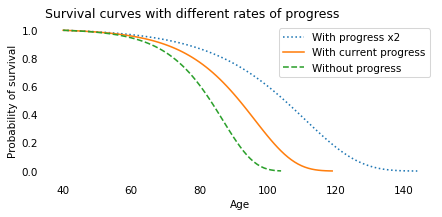

<IPython.core.display.Javascript object>

In [127]:
hazard_progress2.make_surv().plot(ls=":", label="With progress x2")
hazard_progress.make_surv().plot(ls="-", label="With current progress")
hazard_no_progress.make_surv().plot(ls="--", label="Without progress")

decorate(
    xlabel="Age",
    ylabel="Probability of survival",
    title="Survival curves with different rates of progress",
)

The dashed line on the left shows the survival curve we expect if there is no further decrease in mortality rates; in that scenario, life expectancy at age 40 is 82 years and the probability of living to 100 is only 1.4%.

The solid line shows the survival curve if mortality continues to decrease at the current rate; in that case, life expectancy for the same 40-year-old is 90 years and the chance of living to 100 is 25%.

In [128]:
hazard_no_progress.mean(), hazard_progress.mean(), hazard_progress2.mean()

(81.8072010552909, 89.96521174758263, 102.69918506487211)

<IPython.core.display.Javascript object>

In [129]:
hazard_progress3.mean(), hazard_progress4.mean()

(125.0724521213487, 184.72593998355953)

<IPython.core.display.Javascript object>

In [130]:
hazard_no_progress.make_surv()(100)

array(0.01353305)

<IPython.core.display.Javascript object>

In [131]:
hazard_progress.make_surv()(100)

array(0.24964025)

<IPython.core.display.Javascript object>

In [132]:
hazard_progress2.make_surv()([100, 120, 130, 140])

array([0.60379629, 0.17113289, 0.03569291, 0.00159352])

<IPython.core.display.Javascript object>

Finally, the dotted line on the right shows the survival curve if mortality decreases at twice the current rate.
Life expectancy at age 40 would be 102 and the probability of living to 100 would be 60%.

The following figure shows the survival curve under the assumption that mortality rates, starting in 2019, decrease at four times the current rate.

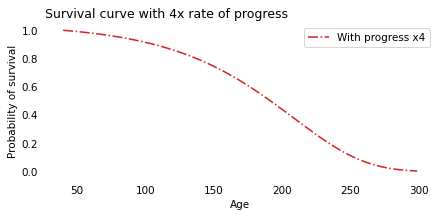

<IPython.core.display.Javascript object>

In [148]:
hazard_progress4.make_surv().plot(color="C3", ls="-.", label="With progress x4")

decorate(
    xlabel="Age",
    ylabel="Probability of survival",
    title="Survival curve with 4x rate of progress",
)

In this scenario, some people live to be 300 years old!
However, even with these optimistic assumptions, the shape of the curve is similar to what we get with slower rates of progress.
And, as shown in the following figure, average remaining lifetimes decrease with almost the same slope.

In [149]:
qs = np.arange(40, hazard_progress4.qs.max())
rem_progress4 = remaining_lifetimes_pmf(hazard_progress4.make_pmf(), qs)

qs = np.arange(40, hazard_progress3.qs.max())
rem_progress3 = remaining_lifetimes_pmf(hazard_progress3.make_pmf(), qs)

qs = np.arange(40, 140)
rem_progress2 = remaining_lifetimes_pmf(hazard_progress2.make_pmf(), qs)

qs = np.arange(40, 120)
rem_progress = remaining_lifetimes_pmf(hazard_progress.make_pmf(), qs)

qs = np.linspace(40, 100)
rem_no_progress = remaining_lifetimes_pmf(hazard_no_progress.make_pmf(), qs)

<IPython.core.display.Javascript object>

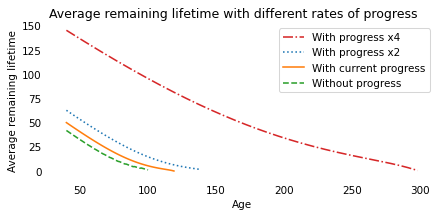

<IPython.core.display.Javascript object>

In [150]:
rem_progress4.plot(color="C3", ls="-.", label="With progress x4")
# rem_progress3.plot(ls=':', label='With progress x3')
rem_progress2.plot(ls=":", label="With progress x2")
rem_progress.plot(ls="-", label="With current progress")
rem_no_progress.plot(ls="--", label="Without progress")

decorate(
    xlabel="Age",
    ylabel="Average remaining lifetime",
    title="Average remaining lifetime with different rates of progress",
)

With faster progress, people live longer, but they still have the new-better-than-used property: as each year passes, they get closer to the grave, on average.

However, something remarkable happens if progress accelerates by a factor of 4.9.
At that speed, the increase in mortality due to aging by one year is exactly offset by the decrease due to progress.
That means that the probability of dying is the same from one year to the next, forever.
The result is a survival curve that looks like this.

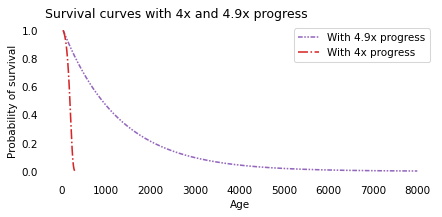

<IPython.core.display.Javascript object>

In [136]:
dashdotdot = (0, (3, 1, 1, 1, 1, 1))

hazard_progress49.make_surv().plot(
    color="C4", ls=dashdotdot, label="With 4.9x progress"
)
hazard_progress4.make_surv().plot(color="C3", ls="-.", label="With 4x progress")

decorate(
    xlabel="Age",
    ylabel="Probability of survival",
    title="Survival curves with 4x and 4.9x progress",
)

The difference between 4 and 4.9 is qualitative.
At a factor of 4, the survival curve plummets toward an inevitable end; at a factor of 4.9, it extends out to ages that are beyond biblical.

In [137]:
lam = hazard_no_progress[40]
lam * 1e4

7.888830027209969

<IPython.core.display.Javascript object>

In [138]:
1 / lam, 2 / lam

(1267.6150919094762, 2535.2301838189524)

<IPython.core.display.Javascript object>

In [139]:
from scipy.stats import expon

dist = expon(scale=1 / lam)
dist.mean(), dist.median()

(1267.6150919094762, 878.6438269922893)

<IPython.core.display.Javascript object>

In [140]:
dist.sf([2000, 4000])

array([0.20643576, 0.04261572])

<IPython.core.display.Javascript object>

In [141]:
dist.ppf(1 - 1 / 7e9)

28735.7893553912

<IPython.core.display.Javascript object>

In the near future, if child mortality continues to decrease, everyone will be better new than used.
But eventually, if adult mortality decreases fast enough, everyone will have the same remaining time, on average: new, used, or in between.

Probably Overthinking It

Copyright 2022 Allen Downey 

The code in this notebook and `utils.py` is under the [MIT license](https://mit-license.org/).